In [2]:
import sys
sys.path.append('/usr/local/lib/python3.11/site-packages') 
import matplotlib.pylab as plt
from matplotlib.patches import Circle

import cartopy.crs as ccrs
import cartopy.feature as cpf
from cartopy.io.shapereader import Reader
import intake
from easygems.healpix import attach_coords, healpix_show, healpix_contour
import easygems.healpix as egh
import numpy as np
import xarray as xr
import seaborn as sn
import geopy.distance
import json


from matplotlib.colors import LinearSegmentedColormap

cat = intake.open_catalog("https://tcodata.mpimet.mpg.de/internal.yaml")

In [3]:
era5 = cat.HERA5(time="PT1H").to_dask().pipe(attach_coords)
era5_daily = cat.HERA5(time="P1D").to_dask().pipe(attach_coords)

In [4]:
cwv_crit = 50.0

In [5]:
coordinates = {'mindeloNorth': 16.88, 'mindeloEast': -24.98, 
               'salNorth': 16.74, 'salEast': -22.94, 
               'bcoNorth': 13.15, 'bcoEast': -59.42,
              }

In [6]:
sel_time = "2023-09-08T19:00:00"

# EC orbits

In [7]:
c_earth = 40075.017      # circumference of earth at equator
spd     = 86400.         # seconds per day
kpd     = c_earth/360    # kilometers per degreen longitude at the equator

t_op = 5552.7
t_cv = 5554.3

n_op = 25
n_cv =  9

def offset(n,t):
    # copmute offset in degrees for the n'th orbit
    return (-c_earth * t/86400. * n/kpd)

In [8]:
def calc_orbits(scenario,wb=330.,eb=340.):
 
    if (scenario == 'operations'): 
        ndays = n_op
        t = t_op
    else:
        ndays = n_cv
        t = t_cv
        scenario = 'calval'
    
    orbits = ndays * spd/t
    print (f'Calculations for {scenario}: {orbits:3g} unique orbits\n')

    lons = np.zeros(int(orbits))
    days = np.zeros(int(orbits))
    
    for i, norbit in enumerate(np.arange(0,int(orbits))):
        lons[i] = offset(norbit,t)%360
        days[i] = norbit*t/86400 + 1
    
    lons_sel =[]
    days_sel = []
    for i,lon in enumerate(lons):
        if (lon > wb and lon < eb) : 
            lons_sel.append(lons[i]-360.0);
            days_sel.append(np.round(days[i]));
            
    return lons_sel,days_sel

def calc_track(sing_lon_ec, edge_south, edge_north, lon_band, same_track_back = True, pointReturn = (np.nan, np.nan)):
    
        # Calculates straight legs connecting the circles and the airport
    
    if lon_band == 'east':
        lat_airport, lon_airpot = coordinates['salNorth'], coordinates['salEast']  

    elif lon_band == 'west':
        lat_airport, lon_airpot = coordinates['bcoNorth'], coordinates['bcoEast'] 

    else:
        lat_airport, lon_airpot = np.nan, np.nan
        
    leg_coords_airport = [(lat_airport, lon_airpot)]
    leg_coords_ec = [(edge_north, sing_lon_ec+(edge_north*np.tan(7/180*np.pi))),
                     (edge_south, sing_lon_ec+(edge_south*np.tan(7/180*np.pi))), 
                    ]
    
    track = leg_coords_airport + leg_coords_ec
    
    if same_track_back:
        return track + track[::-1]
    
    else:
        return track + [pointReturn] + leg_coords_airport

In [9]:
leg_coords = [(coordinates['bcoNorth'], coordinates['bcoEast']),
              (10.0, -40.0),
              (0.0, -40.0),
              (coordinates['bcoNorth'], coordinates['bcoEast'])
             ]

leg_coords2 = [(coordinates['bcoNorth'], coordinates['bcoEast']),
              (9.0, -45.0),
              (3.0, -45.0),
              (coordinates['bcoNorth'], coordinates['bcoEast'])
             ]

leg_coords3 = [(coordinates['bcoNorth'], coordinates['bcoEast']),
              (8.0, -45.0),
              (3.0, -45.0),
              (coordinates['bcoNorth'], coordinates['bcoEast'])
             ]

In [10]:
def calc_length_track(leg_coords): 
        
    distanceKm = 0
    for i_coord in range(len(leg_coords)-1):
        distanceKm += geopy.distance.geodesic(leg_coords[i_coord], leg_coords[i_coord+1]).km
        
    return distanceKm

In [11]:
halo_speed_12km_kmh = 225*3.6

In [12]:
# Load the dictionary from the file
with open("orcestra.json", "r") as file:
    loaded_orcestra = json.load(file)
    
loaded_orcestra

{'domain': {'west': [-46, -41, -5, 25], 'east': [-26, -21, -5, 25]},
 'month': {'west': 9, 'east': 8},
 'settings': {'cwv_thresh': 48, 'cwv_min': 42, 'perc_most': 25},
 'edges': {'east': {'south': 4.480798721313477, 'north': 16.02410125732422},
  'west': {'south': 4.181528091430664, 'north': 13.248014450073242}}}

In [20]:
lat_regions = {'east': {'north': loaded_orcestra["edges"]["east"]["north"], 'south': loaded_orcestra["edges"]["east"]["south"]}, 
               'west': {'north': loaded_orcestra["edges"]["west"]["north"], 'south': loaded_orcestra["edges"]["west"]["south"]}}

returnTrack = {'east': {"pointReturn": None, "same_track_back": True},
               'west': {"pointReturn": (coordinates['bcoNorth'], coordinates['bcoEast']), "same_track_back": False},
}

Calculations for operations: 389 unique orbits

Calculations for operations: 389 unique orbits



NameError: name 'ds' is not defined

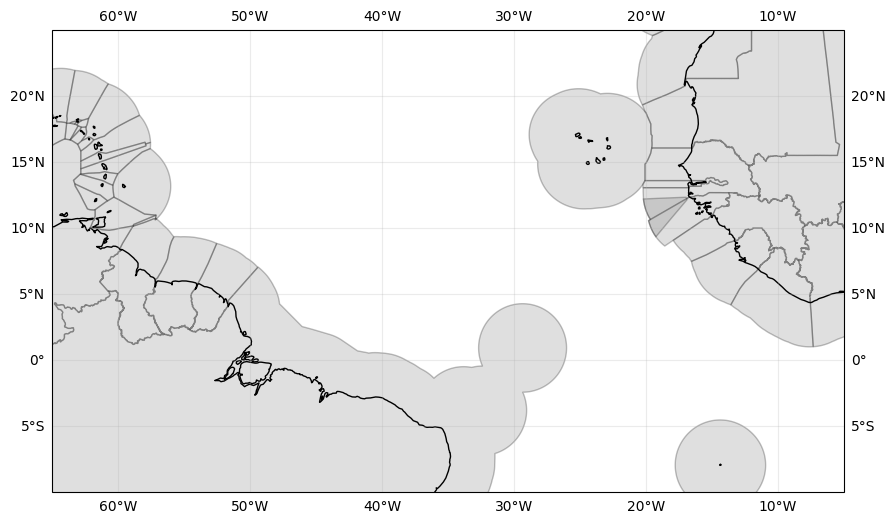

In [18]:
levels_cwv = np.sort(np.unique([cwv_crit, 45, 50, 55]))

plt.figure(figsize = (12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-65, -5, -10, 25], crs=ccrs.PlateCarree())
ax.coastlines(alpha=1.0)
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha = 0.25)

#Add the shapefiles
direc_shp, file_shp = '../TrackPlanning/EEZ_land_union_v3_202003/', 'EEZ_Land_v3_202030.shp'
shape_feature = cpf.ShapelyFeature(Reader(direc_shp+file_shp).geometries(),
                               ccrs.PlateCarree(), edgecolor='black', facecolor='grey', alpha = 0.25)
ax.add_feature(shape_feature,zorder=1)

##Adds EC orbits

ec_tracks = {'east': {'wb': -31+360.0, 'eb': -21+360.0, 'date_start': '2024-08-12'},
             'west': {'wb': -53+360.0, 'eb': -43+360.0, 'date_start': '2024-09-12'},
            }

for region in ['east', 'west']:
    
    lon_ec,time_ec = calc_orbits('operations',wb=ec_tracks[region]['wb'],eb=ec_tracks[region]['eb'])
    time_ec = np.array(time_ec+np.datetime64(ec_tracks[region]['date_start'],'D').astype(int), dtype='datetime64[D]')
    lat_ec = np.zeros(len(lon_ec))
    
    ec_tracks[region]['lon_ec'] = lon_ec
    ec_tracks[region]['lat_ec'] = lat_ec

ec_lat_max = 25

## Adds southern and northern edge frequency
cm_north = LinearSegmentedColormap.from_list("north", colors=[plt.get_cmap("Blues")(i)[:3] + (i/255,) for i in range(plt.get_cmap("Reds").N)])
cm_south = LinearSegmentedColormap.from_list("south", colors=[plt.get_cmap("Greens")(i)[:3] + (i/255,) for i in range(plt.get_cmap("Blues").N)])
map_extent = [-65, -5, -10, 25]

month_sel = 9

ds.freq_n_edge.sel(month=month_sel).plot.imshow(x="longitude_bin",y='latitude_bin', vmax=0.015, cmap=cm_north, add_colorbar=False, extent=[-60, -10, -10, 25], transform=ccrs.PlateCarree())
ds.freq_s_edge.sel(month=month_sel).plot.imshow(x="longitude_bin",y='latitude_bin', vmax=0.015, cmap=cm_south, add_colorbar=False, extent=[-60, -10, -10, 25],transform=ccrs.PlateCarree())

worst_case_north.plot(color = 'C0')
worst_case_south.plot(color = 'darkgreen')
    

ec_lat_min = -10

for region in ['east', 'west']:
    lon_ec = ec_tracks[region]['lon_ec']
    for i in range(len(lon_ec)):
        plt.plot([lon_ec[i]+(ec_lat_min*np.tan(7/180*np.pi)),lon_ec[i]+(ec_lat_max*np.tan(7/180*np.pi))],
                 [ec_lat_min,ec_lat_max], color = 'k', alpha=0.4)

number_circles = 3
duration_circle_h = 1

extra_time_landing_takeoff_h = 1.0



#(lat_regions['west']['north'], ec_tracks['west']['wb']-360.0)

#pointReturnNorth, pointReturnEast = 

for region in ['east', 'west']:
    print(region)
    lon_ec = ec_tracks[region]['lon_ec']
    lat_min, lat_max = lat_regions[region]['south'], lat_regions[region]['north']
    
    for i_ec, sing_lon_ec in enumerate(np.sort(lon_ec)):
        
        track_s = calc_track(sing_lon_ec, 
                             lat_min, 
                             lat_max, 
                             region, 
                             same_track_back=returnTrack[region]["same_track_back"], 
                             pointReturn=returnTrack[region]["pointReturn"])

        track_length_km = calc_length_track(track_s)
        duration_h = (track_length_km/halo_speed_12km_kmh) + number_circles*duration_circle_h + extra_time_landing_takeoff_h

        flightLat, flightLon  = zip(*track_s)
        plt.plot(flightLon, flightLat, c = 'C1')
        #print(f"{sing_lon_ec:.2f}, {duration_h:.2f} h {flightLat, flightLon}")
        print(f"({i_ec+1}) EC long. at equator: {sing_lon_ec:.2f}, estimated flight duration: {duration_h:.2f} h")    

west
(1) EC long. at equator: -52.75, estimated flight duration: 7.92 h
(2) EC long. at equator: -51.83, estimated flight duration: 8.13 h
(3) EC long. at equator: -50.90, estimated flight duration: 8.34 h
(4) EC long. at equator: -49.98, estimated flight duration: 8.55 h
(5) EC long. at equator: -49.05, estimated flight duration: 8.77 h
(6) EC long. at equator: -48.12, estimated flight duration: 8.99 h
(7) EC long. at equator: -47.20, estimated flight duration: 9.22 h
(8) EC long. at equator: -46.27, estimated flight duration: 9.45 h
(9) EC long. at equator: -45.35, estimated flight duration: 9.68 h
(10) EC long. at equator: -44.42, estimated flight duration: 9.91 h
(11) EC long. at equator: -43.50, estimated flight duration: 10.14 h


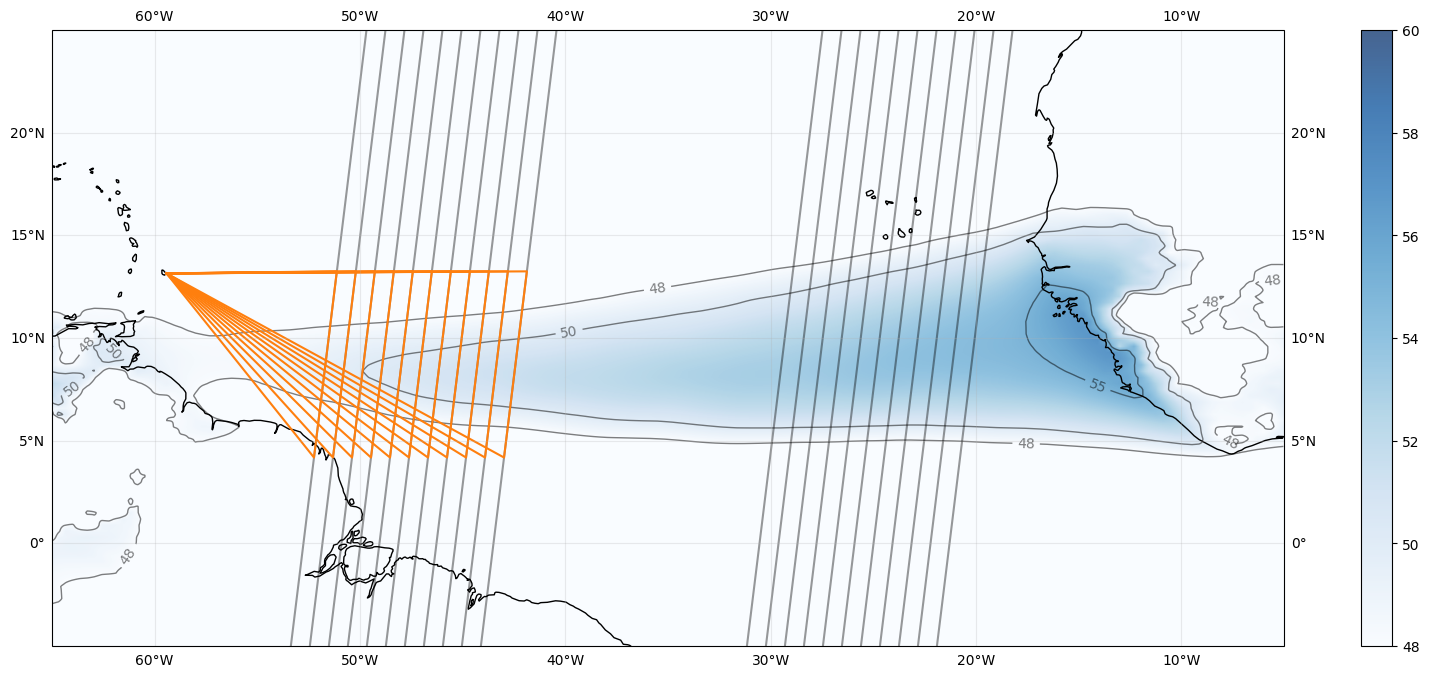

In [22]:
levels_cwv = np.sort(np.unique([loaded_orcestra["settings"]["cwv_thresh"], 50, 55]))

plt.figure(figsize = (20, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-65, -5, -5, 25], crs=ccrs.PlateCarree())
ax.coastlines(alpha=1.0)
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha = 0.25)

field = era5_daily.tcwv.where(era5.time.dt.month.isin([8, 9]), drop=True).mean("time")

im = healpix_show(field, method="linear",
                  alpha = 0.75, cmap = 'Blues', vmin = loaded_orcestra["settings"]["cwv_thresh"], vmax = 60)
plt.colorbar(im)

contour_lines = healpix_contour(field,
                                levels=levels_cwv, colors='k', linewidths=1, alpha = 0.5)

plt.clabel(contour_lines, inline=True, fontsize=10, colors='k', fmt='%d')

ec_lat_min, ec_lat_max = -5, 25

for region in ['east', 'west']:
    lon_ec = ec_tracks[region]['lon_ec']
    for i in range(len(lon_ec)):
        plt.plot([lon_ec[i]+(ec_lat_min*np.tan(7/180*np.pi)),lon_ec[i]+(ec_lat_max*np.tan(7/180*np.pi))],
                 [ec_lat_min,ec_lat_max], color = 'k', alpha=0.4)

number_circles = 3
duration_circle_h = 1

extra_time_landing_takeoff_h = 1.0


for region in ['west']:
    print(region)
    lon_ec = ec_tracks[region]['lon_ec']
    lat_min, lat_max = lat_regions[region]['south'], lat_regions[region]['north']
    
    for i_ec, sing_lon_ec in enumerate(np.sort(lon_ec)):
        
        track_s = calc_track(sing_lon_ec, 
                             lat_min, 
                             lat_max, 
                             region, 
                             same_track_back=returnTrack[region]["same_track_back"], 
                             pointReturn=returnTrack[region]["pointReturn"])

        track_length_km = calc_length_track(track_s)
        duration_h = (track_length_km/halo_speed_12km_kmh) + number_circles*duration_circle_h + extra_time_landing_takeoff_h

        flightLat, flightLon  = zip(*track_s)
        plt.plot(flightLon, flightLat, c = 'C1')
        #print(f"{sing_lon_ec:.2f}, {duration_h:.2f} h {flightLat, flightLon}")
        print(f"({i_ec+1}) EC long. at equator: {sing_lon_ec:.2f}, estimated flight duration: {duration_h:.2f} h")    
        
plt.savefig("worst_case_planning_cwv.pdf")